In [1]:
#@title 1. MONTAR EL DRIVE  { display-mode: "form" }
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/AI I UIS/Proyecto')
print(os.getcwd())

Mounted at /content/drive
/content/drive/My Drive/AI I UIS/Proyecto


In [77]:
#@title 2. Instalar dependencias  { display-mode: "form" }
!pip install gradio
!pip install keras-tuner

In [79]:
#@title **Load libs** { display-mode: "form" }
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import timeit
import cv2 as cv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras import backend as K
import kerastuner as kt
from keras.models import load_model

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

import gradio as gr

In [81]:
warnings.filterwarnings('ignore')

In [82]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [83]:
#@title Define path to data
annotations_dir = 'Dataset/Annotation'
images_dir = 'Dataset/Images'

In [84]:
# Count the number of classes (dogs breeds)
breed_list = os.listdir(images_dir)
print("Number of breeds in dataset:", (len(breed_list)))

Number of breeds in dataset: 120


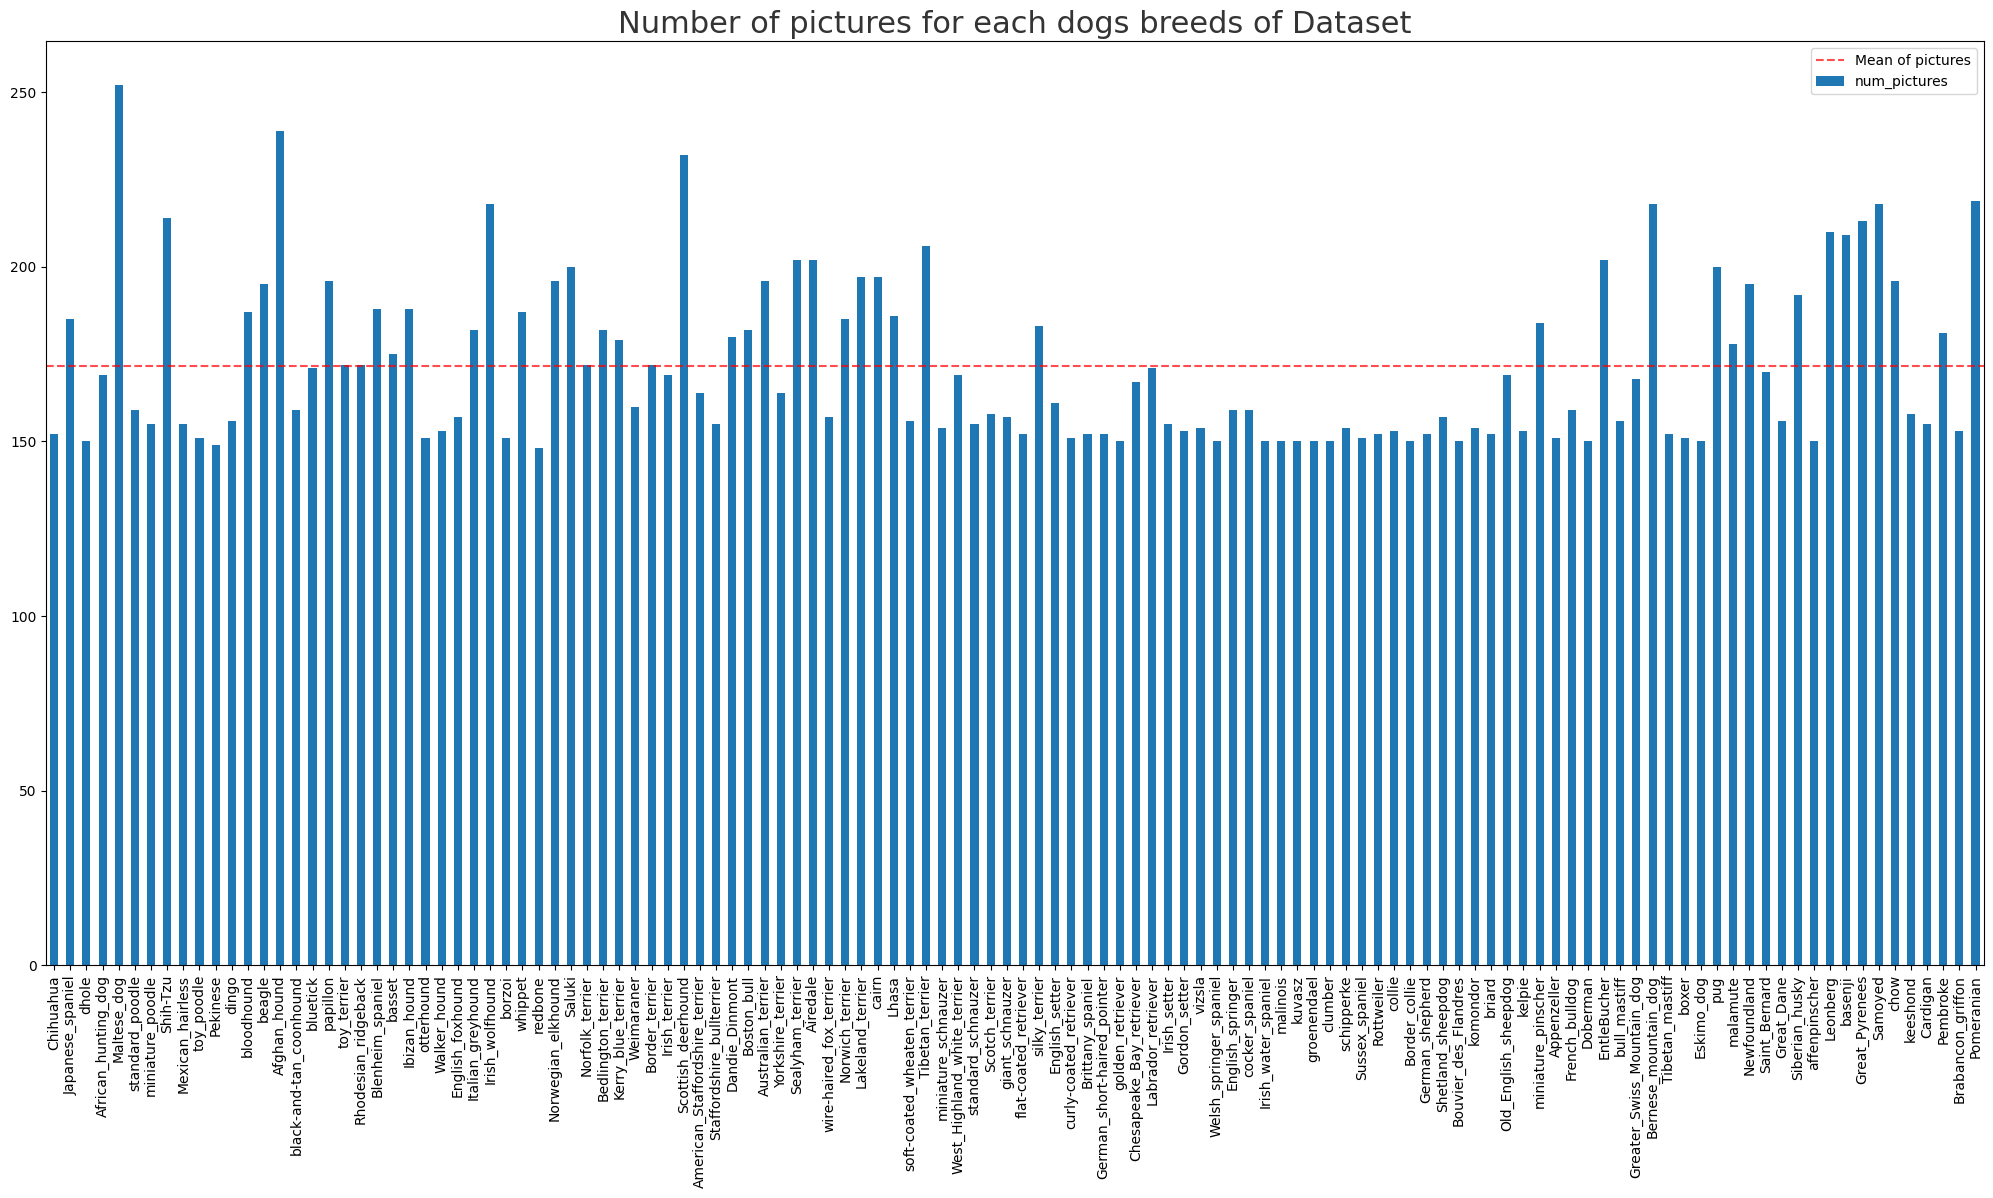

In [85]:
#@title Mean of images per class
df_breeds = pd.DataFrame(
    index=[breed.split('-',1)[1]
           for breed in breed_list],
    data=[len(os.listdir(images_dir + "/" + name))
          for name in breed_list],
    columns=["num_pictures"])

# Plot results
fig, ax = plt.subplots(1, 1, figsize=(25,12))
df_breeds.plot(kind="bar",
               legend=False,
               ax=ax)
ax.axhline(df_breeds["num_pictures"].mean(),
           color='r', alpha=.7,
           linestyle='--',
           label="Mean of pictures")
plt.title("Number of pictures for each "\
          "dogs breeds of Dataset",
          color="#343434", fontsize=22)
plt.legend()
plt.show()

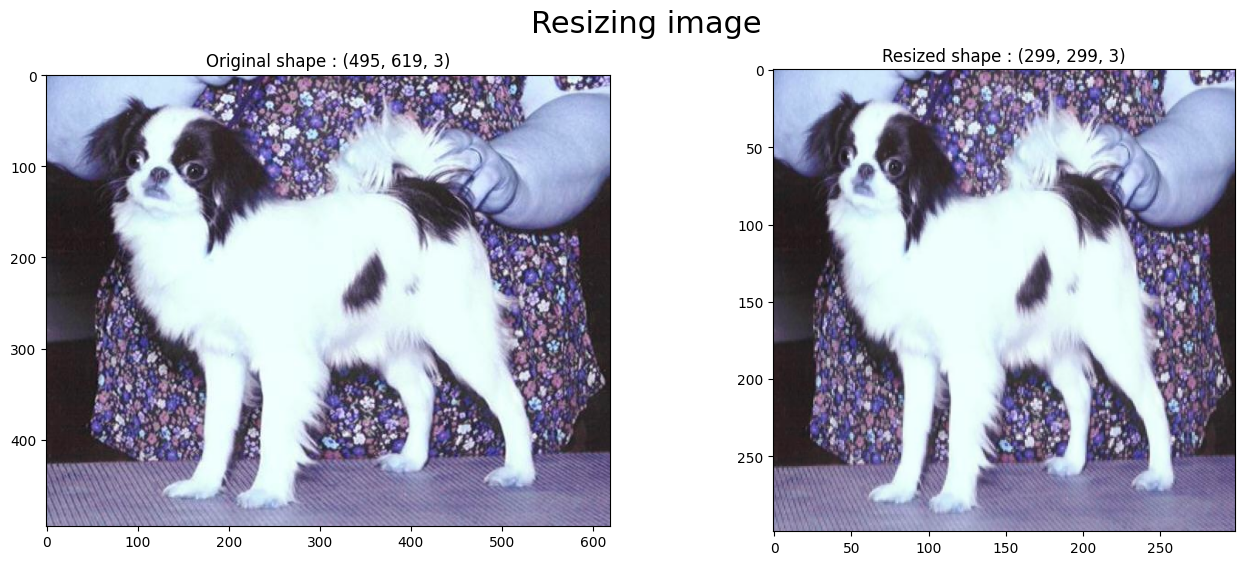

In [107]:
#@title Test image and resize
img_test = (images_dir
            + "/"
            + "n02085782-Japanese_spaniel/n02085782_1626.jpg")
img_test = cv.imread(img_test)
# setting dim of the resize
height = 299
width = 299
dim = (width, height)
# resize image with OpenCV
res_img = cv.resize(img_test, dim, interpolation=cv.INTER_LINEAR)

# Show both img
fig = plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.imshow(img_test)
plt.title("Original shape : {}".format(img_test.shape))
plt.subplot(1, 2, 2)
plt.imshow(res_img)
plt.title("Resized shape : {}".format(res_img.shape))
plt.suptitle("Resizing image",
             color="black",
             fontsize=22, y=.98)
plt.show()

In [89]:
def preprocessing_cnn(directories, img_width, img_height):
    """Preprocesamiento de imágenes para integrarlas
    en una red neuronal convolucional. También se
    realiza la creación simultánea de etiquetas (y).
    """
    img_list=[]
    labels=[]
    for index, breed in enumerate(directories):
        for image_name in os.listdir(images_dir+"/"+breed):
            # Read image
            img = cv.imread(images_dir+"/"+breed+"/"+image_name)
            img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
            # Resize image
            dim = (img_width, img_height)
            img = cv.resize(img, dim, interpolation=cv.INTER_LINEAR)
            # Convert modified img to array
            img_array = image.img_to_array(img)

            # Append lists of labels and images
            img_list.append(np.array(img_array))
            labels.append(breed.split("-")[1])

    return img_list, labels

In [90]:
#@title List of breeds to use.
fr_breed_list = [
    'n02096294-Australian_terrier',
    'n02093256-Staffordshire_bullterrier',
    'n02099601-golden_retriever',
    'n02106662-German_shepherd',
    'n02086240-Shih-Tzu',
    'n02099712-Labrador_retriever',
    'n02110185-Siberian_husky',
    'n02106166-Border_collie',
    'n02106550-Rottweiler']

In [91]:
#@title Image processing

# Define numbers of breeds to preprocess
num_breeds = len(fr_breed_list)

# Execute preprocessor on selection
start_time = timeit.default_timer()
# X = images
# y = labels
X, y = preprocessing_cnn(fr_breed_list, 299, 299)
# Convert in numpy array
X = np.array(X)
y = np.array(y)
preprocess_time = timeit.default_timer() - start_time
print("-" * 50)
print("Execution time for preprocessing :")
print("-" * 50)
print("Number of images preprocessed : {}"\
     .format(len(y)))
print("Shape of images np.array : {}"\
     .format(X.shape))
print("Total time : {:.2f}s".format(preprocess_time))

--------------------------------------------------
Execution time for preprocessing :
--------------------------------------------------
Number of images preprocessed : 1532
Shape of images np.array : (1532, 299, 299, 3)
Total time : 17.23s


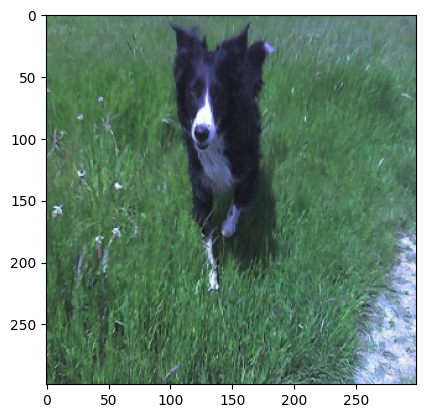

In [92]:
# Show exemple preprocessed image
plt.imshow(image.array_to_img(X[1234]))

In [93]:
#@title Shuffling the images
# Using np.shuffle
img_space = np.arange(X.shape[0])
np.random.seed(8)
# Shuffle the space
np.random.shuffle(img_space)
# Apply to X and y in same order
X = X[img_space]
y = y[img_space]

In [94]:
#@title Encoding lables
# Change X type
X = X.astype(np.float32)
# Encode y text data in numeric
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [95]:
# Verifie encoder created classes
print(encoder.classes_)

['Australian_terrier' 'Border_collie' 'German_shepherd'
 'Labrador_retriever' 'Rottweiler' 'Shih' 'Siberian_husky'
 'Staffordshire_bullterrier' 'golden_retriever']


In [20]:
### Create train and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

print("-" * 50)
print("Size of created sets :")
print("-" * 50)
print("Train set size = ",x_train.shape[0])
print("Test set size = ",x_test.shape[0])

--------------------------------------------------
Size of created sets :
--------------------------------------------------
Train set size =  1378
Test set size =  154


In [21]:
#@title Data generator for training and augmentation
# Data generator on train set with Data Augmentation
# Validation set is define here
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

#For validation and test, just rescale
test_datagen = ImageDataGenerator(rescale=1./255)

In [22]:
#@title Custom recall, precision and f1 functions
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [23]:
model = Sequential()
# Convolution layers
model.add(Conv2D(32, (3,3), input_shape=(299,299,3), activation='relu'))
model.add(Conv2D(32, (3,3), activation='relu'))
# Pooling layer
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
# Convolution layers
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(Conv2D(32, (3,3), activation='relu'))
# Pooling layer
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
# Flatten layer
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_breeds, activation='softmax'))

In [24]:
# Compile the CNN Model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", f1_m])

In [25]:
history = model.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    steps_per_epoch=len(x_train) / 32,
    epochs=10,
    verbose=2)

Epoch 1/10
43/43 - 34s - loss: 2.1991 - accuracy: 0.1309 - f1_m: 9.1949 - val_loss: 2.1950 - val_accuracy: 0.1236 - val_f1_m: 9.8103 - 34s/epoch - 780ms/step
Epoch 2/10
43/43 - 22s - loss: 2.1915 - accuracy: 0.1565 - f1_m: 9.5307 - val_loss: 2.1781 - val_accuracy: 0.1527 - val_f1_m: 9.6617 - 22s/epoch - 515ms/step
Epoch 3/10
43/43 - 22s - loss: 2.1820 - accuracy: 0.1437 - f1_m: 9.1791 - val_loss: 2.1795 - val_accuracy: 0.1455 - val_f1_m: 9.1530 - 22s/epoch - 518ms/step
Epoch 4/10
43/43 - 21s - loss: 2.1743 - accuracy: 0.1719 - f1_m: 9.1387 - val_loss: 2.1674 - val_accuracy: 0.1345 - val_f1_m: 9.6100 - 21s/epoch - 484ms/step
Epoch 5/10
43/43 - 21s - loss: 2.1665 - accuracy: 0.1536 - f1_m: 9.2197 - val_loss: 2.1532 - val_accuracy: 0.1709 - val_f1_m: 9.4181 - 21s/epoch - 496ms/step
Epoch 6/10
43/43 - 22s - loss: 2.1460 - accuracy: 0.1662 - f1_m: 8.7294 - val_loss: 2.1487 - val_accuracy: 0.1782 - val_f1_m: 9.5007 - 22s/epoch - 506ms/step
Epoch 7/10
43/43 - 23s - loss: 2.1088 - accuracy: 0.

In [26]:
def plot_history_scores(dict_history, first_score, second_score):
    with plt.style.context('seaborn-whitegrid'):
        fig = plt.figure(figsize=(25,10))
        # summarize history for accuracy
        plt.subplot(1, 2, 1)
        plt.plot(dict_history.history[first_score], color="g")
        plt.plot(dict_history.history['val_' + first_score],
                 linestyle='--', color="orange")
        plt.title('CNN model ' + first_score, fontsize=18)
        plt.ylabel(first_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        # summarize history for loss
        plt.subplot(1, 2, 2)
        plt.plot(dict_history.history[second_score], color="g")
        plt.plot(dict_history.history['val_' + second_score],
                 linestyle='--', color="orange")
        plt.title('CNN model ' + second_score, fontsize=18)
        plt.ylabel(second_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

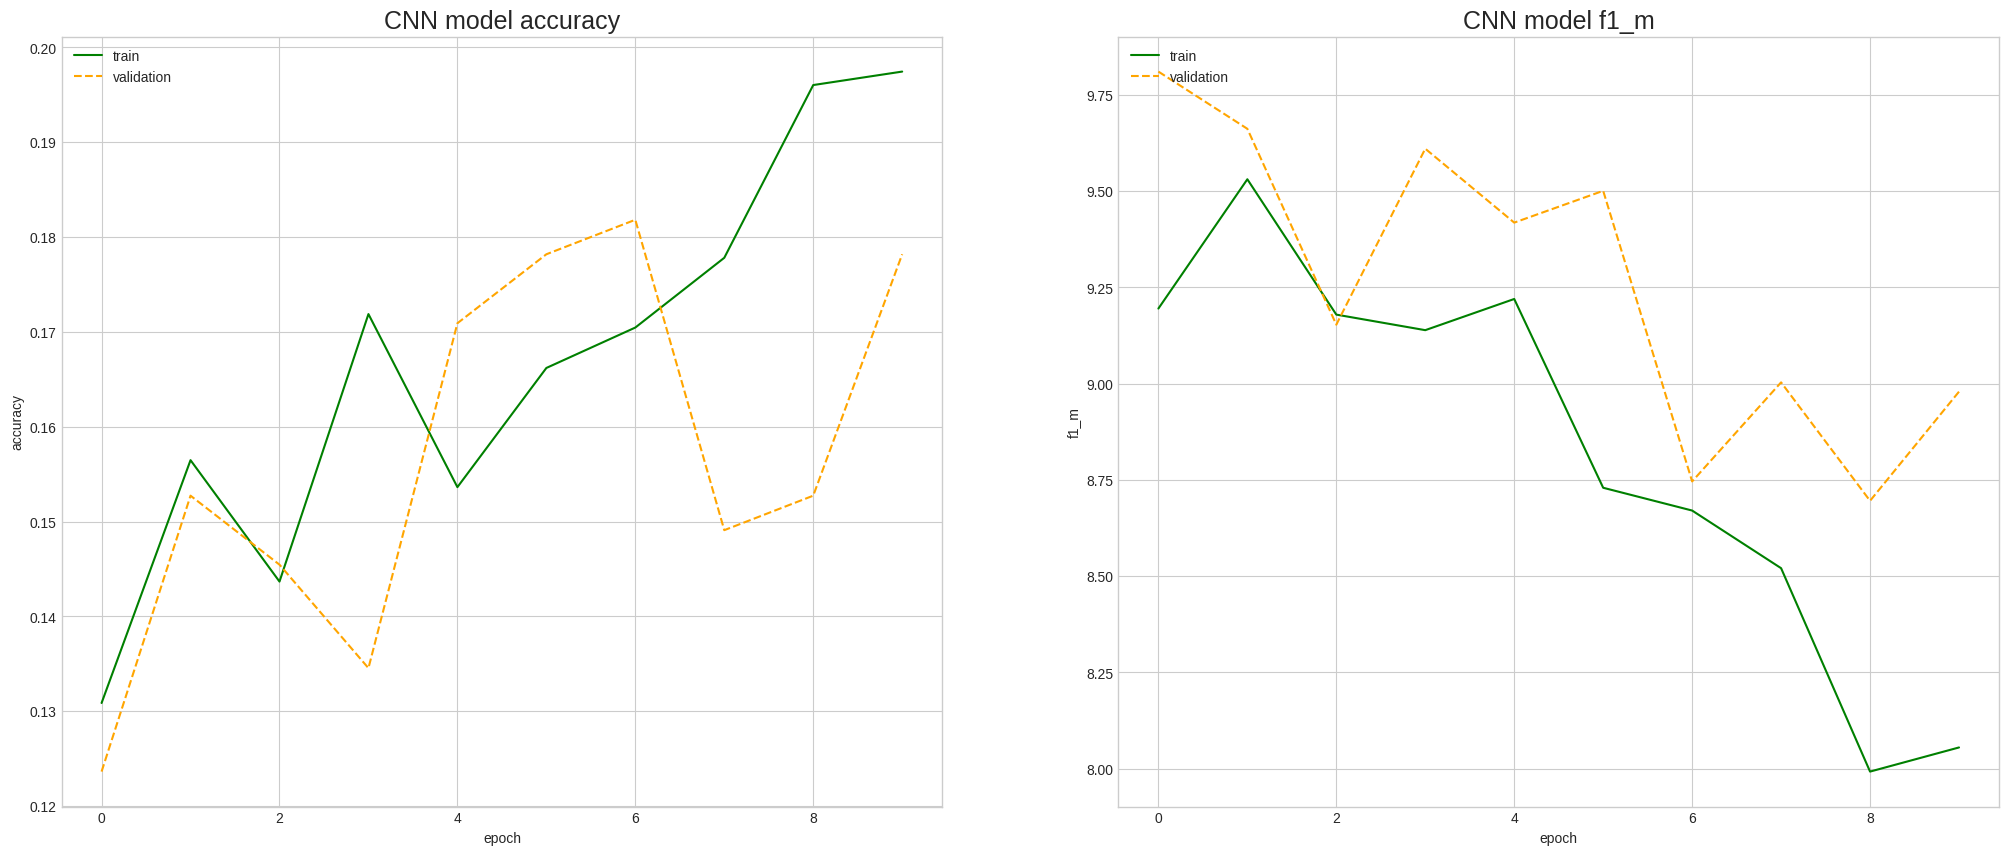

In [27]:
plot_history_scores(
    dict_history = history,
    first_score = "accuracy",
    second_score = "f1_m")

In [28]:
K.clear_session()
# Import Xception trained model
xception_model = tf.keras.applications.xception.Xception(
    weights='imagenet',
    include_top=False,
    pooling='avg',
    input_shape=(299,299,3))

# look at the differents layers
print("-" * 50)
print("Xception base model layers :")
print("-" * 50)
for layer in xception_model.layers:
    print(layer)
    layer.trainable = False

83683744/83683744 [==============================] - 0s 0us/step
--------------------------------------------------
Xception base model layers :
--------------------------------------------------


In [29]:
# Add new fully-connected layers
base_output = xception_model.output
base_output = Dense(128, activation='relu')(base_output)
base_output = Dropout(0.2)(base_output)
# Output : new classifier
predictions = Dense(num_breeds, activation='softmax')(base_output)

# Define new model
my_xcept_model = Model(inputs=xception_model.input,
                       outputs=predictions)
my_xcept_model.compile(optimizer="adam",
                       loss="sparse_categorical_crossentropy",
                       metrics=["accuracy", f1_m])

In [30]:
Xception_plot = plot_model(my_xcept_model,
                           to_file='xcept_model_plot.png',
                           show_shapes=True,
                           show_layer_names=False)

In [31]:
# Data generator on train set with Data Augmentation
# and preprocess_input Xception
# Validation set is define here
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.xception.preprocess_input)

#For validation and test, just rescale
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input)

In [32]:
history_xcept = my_xcept_model.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    steps_per_epoch=len(x_train) / 32,
    epochs=10,
    verbose=2)

Epoch 1/10
43/43 - 34s - loss: 0.5025 - accuracy: 0.8636 - f1_m: 1.9838 - val_loss: 0.1358 - val_accuracy: 0.9564 - val_f1_m: 1.0085 - 34s/epoch - 791ms/step
Epoch 2/10
43/43 - 23s - loss: 0.1334 - accuracy: 0.9560 - f1_m: 1.0316 - val_loss: 0.1191 - val_accuracy: 0.9709 - val_f1_m: 1.0720 - 23s/epoch - 528ms/step
Epoch 3/10
43/43 - 27s - loss: 0.0878 - accuracy: 0.9687 - f1_m: 0.9981 - val_loss: 0.1191 - val_accuracy: 0.9673 - val_f1_m: 1.0112 - 27s/epoch - 633ms/step
Epoch 4/10
43/43 - 23s - loss: 0.0759 - accuracy: 0.9730 - f1_m: 1.0217 - val_loss: 0.1026 - val_accuracy: 0.9745 - val_f1_m: 0.9743 - 23s/epoch - 541ms/step
Epoch 5/10
43/43 - 22s - loss: 0.0611 - accuracy: 0.9829 - f1_m: 0.9966 - val_loss: 0.0938 - val_accuracy: 0.9673 - val_f1_m: 0.9748 - 22s/epoch - 516ms/step
Epoch 6/10
43/43 - 23s - loss: 0.0564 - accuracy: 0.9830 - f1_m: 0.9913 - val_loss: 0.1102 - val_accuracy: 0.9709 - val_f1_m: 1.0178 - 23s/epoch - 528ms/step
Epoch 7/10
43/43 - 23s - loss: 0.0483 - accuracy: 0.

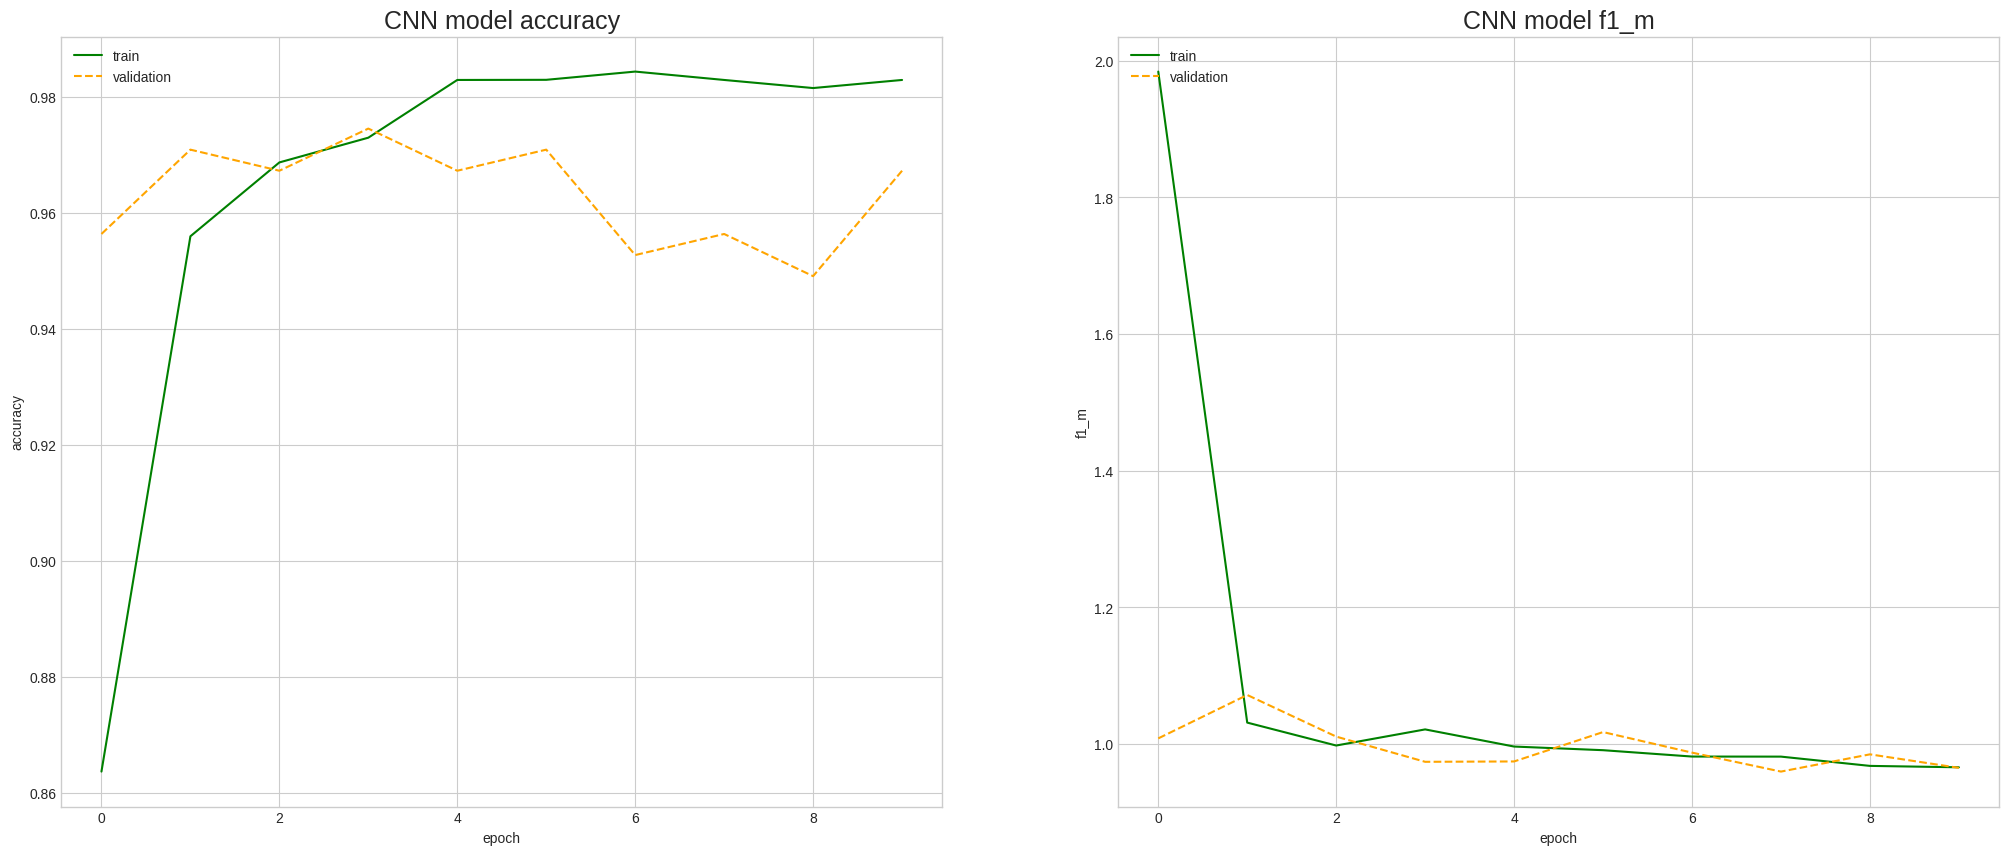

In [33]:
plot_history_scores(
    dict_history = history_xcept,
    first_score = "accuracy",
    second_score = "f1_m")

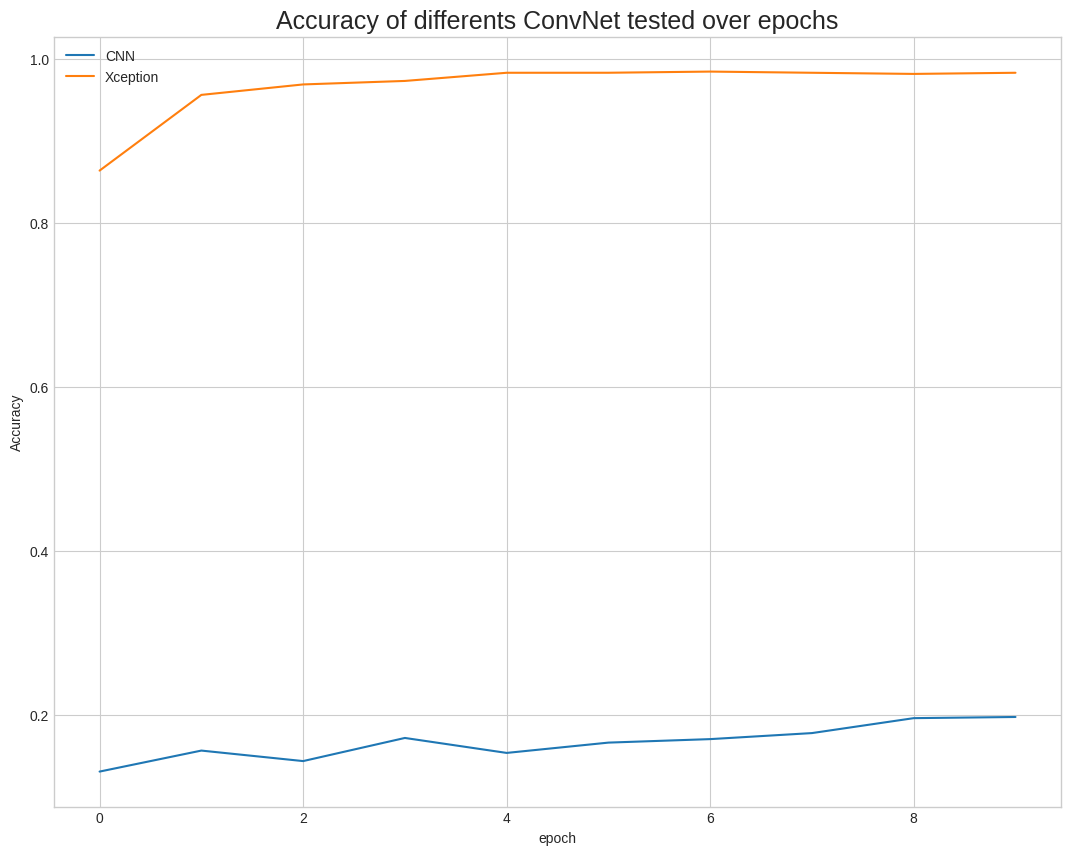

In [34]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(13,10))
    plt.plot(history.history['accuracy'],
             label='CNN')
    plt.plot(history_xcept.history['accuracy'],
             label='Xception')
    plt.title('Accuracy of differents ConvNet tested over epochs',
              fontsize=18)
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

In [35]:
xcept_mean_accuracy = np.mean(history_xcept.history['val_accuracy'])
xcept_mean_f1 = np.mean(history_xcept.history['val_f1_m'])
print("-" * 50)
print("Xception base model validation Scores :")
print("-" * 50)
print("Mean validation accuracy: {:.2f}"\
      .format(xcept_mean_accuracy))
print("Mean validation F1 score: {:.2f}"\
      .format(xcept_mean_f1))

--------------------------------------------------
Xception base model validation Scores :
--------------------------------------------------
Mean validation accuracy: 0.96
Mean validation F1 score: 1.00


In [61]:
# Save the last model
history_xcept.model.save('xception_trained_model.h5')
print("Last model saved")

Last model saved


In [97]:

# Función para cargar el modelo entrenado
def load_trained_model(model_path, custom_objects):
    return keras.models.load_model(model_path, custom_objects={"f1_m": f1_m})

# Función de predicción
def breed_prediction(model, encoder, num_breeds, img_path):
    # Cargar la imagen
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    # Redimensionar imagen
    dim = (299, 299)
    img = cv.resize(img, dim, interpolation=cv.INTER_LINEAR)

    # Equalización de histograma en el canal YUV
    img_yuv = cv.cvtColor(img, cv.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv.equalizeHist(img_yuv[:,:,0])
    img_equ = cv.cvtColor(img_yuv, cv.COLOR_YUV2RGB)

    # Aplicar filtro de medios no locales
    dst_img = cv.fastNlMeansDenoisingColored(
        src=img_equ,
        dst=None,
        h=10,
        hColor=10,
        templateWindowSize=7,
        searchWindowSize=21
    )

    # Convertir imagen a array y preparar para la entrada del modelo
    img_array = keras.preprocessing.image.img_to_array(dst_img)
    img_array = img_array.reshape((-1, 299, 299, 3))
    img_array = tf.keras.applications.xception.preprocess_input(img_array)

    # Realizar la predicción
    prediction = model.predict(img_array).flatten()

    # Devolver predicción
    return {encoder.classes_[i]: float(prediction[i]) for i in range(num_breeds)}

In [105]:
print('Breeds:')
for breed in encoder.classes_:
    print(f"- {breed}")

Breeds:
- Australian_terrier
- Border_collie
- German_shepherd
- Labrador_retriever
- Rottweiler
- Shih
- Siberian_husky
- Staffordshire_bullterrier
- golden_retriever


1/1 [==============================] - 0s 24ms/step
Predicción:
- golden_retriever: 0.9940114617347717


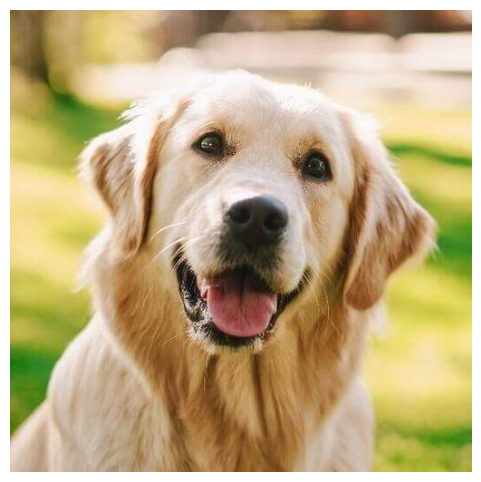

In [106]:
# Ejemplo de imagen para predecir (ajustar según tu caso)
example_image_path = 'retriever.jpg'

# Realizar la predicción
prediction_result = breed_prediction(model, encoder, num_breeds, example_image_path)

# Mostrar los resultados
print("Predicción:")
for breed, probability in prediction_result.items():
  if probability > 0.5:
    print(f"- {breed}: {probability}")

# Mostrar la imagen de ejemplo
plt.figure(figsize=(6, 6))
img = cv.imread(example_image_path)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()